<!-- HTML file automatically generated from DocOnce source (https://github.com/doconce/doconce/)
doconce format html Project2.do.txt  -->
<!-- dom:TITLE: Project 2 on Machine Learning, deadline November 10 (Midnight) -->

# Project 2 on Machine Learning - Building a Neural Network Code
**[Data Analysis and Machine Learning FYS-STK3155/FYS4155](http://www.uio.no/studier/emner/matnat/fys/FYS3155/index-eng.html)**, University of Oslo, Norway

#### Pietro Perrone pietrope@uio.no

### Dependencies


In [19]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
import sys
import random
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from autograd import grad
import copy
import time
from typing import Literal, List, Optional

# own functions
from ml_project1.functions import *
from ml_project2.functions import *

from matplotlib import rcParams
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = r'\usepackage{sansmathfonts}'
rcParams.update({
    "font.size": 9,       
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    'axes.titlesize':9
})
plt.rc("legend", fontsize=9)
def saveplot(plotname):
    return plt.savefig("../LaTeX/images/{}.pdf".format(str(plotname)))
cw = 8.325/2.54
tw = 17/2.54

## Activation functions

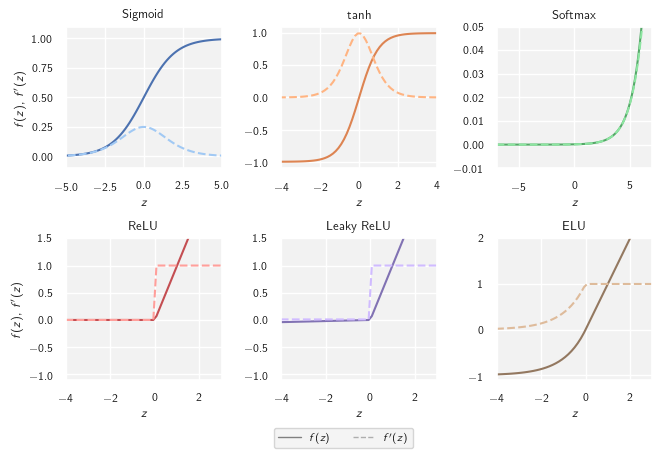

In [2]:
fig, axes = plt.subplots(2, 3, figsize=(tw, 12/2.54))
z = np.linspace(-7, 7, 100)
axes = axes.flatten()
xlims=[
    (-5, 5),
    (-4, 4),
    (-7, 7),
    (-4, 3),
    (-4, 3),
    (-4, 3)
]
ylims = [
    (-0.1, 1.1),
    (-1.1, 1.1),
    (-0.01, 0.05),
    (-1.1, 1.5),
    (-1.1, 1.5),
    (-1.1, 2),
]

labels = ['Sigmoid', r'$\tanh$', 'Softmax', 'ReLU', 'Leaky ReLU', 'ELU']

cbar_activ = sns.color_palette(n_colors=6)
cbar_der = sns.color_palette('pastel', n_colors=6)

for i, key in enumerate(activation_functions_dic):
    activation_func, activation_der = activation_functions_dic[key]
    axes[i].plot(z, activation_func(z), 
                 color=cbar_activ[i],
                 label=r"$f(z)$" if i==4 else None)
    axes[i].plot(z, activation_der(z),
                 color=cbar_der[i],
                 label=r"$f'(z)$" if i==4 else None,
                 linestyle='--')
    axes[i].set_xlim(xlims[i])
    axes[i].set_ylim(ylims[i])
    axes[i].set_title(f"{labels[i]}")
    axes[i].set_xlabel(r"$z$")

axes[3].set_ylabel(r"$f(z),\,f'(z)$")
axes[0].set_ylabel(r"$f(z),\,f'(z)$")

import matplotlib.lines as mlines
legend_elements = [
    mlines.Line2D([], [], color='gray', linestyle='-', label=r'$f(z)$', linewidth=1),
    mlines.Line2D([], [], color='gray', linestyle='--', alpha=0.6, label=r"$f'(z)$", linewidth=1)
]

# Place unified legend centered below plot number 5 (index 4)
axes[4].legend(handles=legend_elements, bbox_to_anchor=(0.4, -0.3), 
               loc='upper center', ncol=2, fontsize=8)

plt.tight_layout()
saveplot("activation_functions")
plt.show()
    

## Preprocessing
### Creation of input dataset
train-test split, scaling

In [3]:
x = np.linspace(-1, 1, 100).reshape(-1, 1)
y = Runge(x, noise=False)
print(x.shape)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x = scaler.transform(x)

(100, 1)


## Testing `NeuralNetwork` class

In [10]:
nn = NeuralNetwork(
    network_input_size=1,
    layer_output_sizes=[100, 100, 1],
    activation_types=['sigmoid', 'sigmoid', 'sigmoid'],
    cost_type='mse'
)

### Verifying automatic differantiation
Check if `autograd` works and yields same results as manual differantiation

In [20]:
nn_manualdiff = NeuralNetwork(
    network_input_size=1,
    layer_output_sizes=[100, 100, 1],
    activation_types=['sigmoid', 'sigmoid', 'sigmoid'],
    cost_type='mse',
    autodiff=False
)

nn_autodiff = NeuralNetwork(
    network_input_size=1,
    layer_output_sizes=[100, 100, 1],
    activation_types=['sigmoid', 'sigmoid', 'sigmoid'],
    cost_type='mse',
    autodiff=True
)

In [ ]:
y_noise = Runge(x, noise=False)
nn_manualdiff._create_layers()
nn_manualdiff._define_scheduler(type="adam", eta=1e-3)
nn_manualdiff._train(x_train, y_train, n_epochs=1000, n_batches=20)
y_pred_test_md = nn_manualdiff._predict(x_test).reshape(-1)
y_pred_train_md = nn_manualdiff._predict(x_train).reshape(-1)

nn_autodiff._create_layers()
nn_autodiff._define_scheduler(type="adam", eta=1e-3)
nn_autodiff._train(x_train, y_train, n_epochs=1000, n_batches=20)
y_pred_test_ad = nn_autodiff._predict(x_test).reshape(-1)
y_pred_train_ad = nn_autodiff._predict(x_train).reshape(-1)

plt.figure(figsize=(12, 8))
plt.scatter(x, y_noise, alpha=0.5, label='True data', s=10)
plt.plot(x_test, y_pred_test_md, 'r-', label='Manual diff - Test', linewidth=2)
plt.plot(x_train, y_pred_train_md, 'r--', label='Manual diff - Train', alpha=0.7)
plt.plot(x_test, y_pred_test_ad, 'g-', label='Auto diff - Test', linewidth=2) 
plt.plot(x_train, y_pred_train_ad, 'g--', label='Auto diff - Train', alpha=0.7)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Neural Network Predictions vs True Runge Function')
plt.show()

TypeError: grad_np_mean() got an unexpected keyword argument 'dtype'

### Testing different schedulers
**Plain SGD, RMSProp, ADAM**

In [9]:
etas_range = [1e-2, 0.5e-2, 1e-3, 0.5e-3, 1e-4, 0.5e-4, 1e-5]
epochs_range = [100, 250, 500, 1000, 2500, 5000]
schedulers_types = ['constant', 'rmsprop', 'adam']

mse_matrices = list()
r2_matrices = list()

for scheduler in schedulers_types:
    start_time = time.time()
    print(f"Starting at time: {start_time}")
    mse_matrix = np.zeros((len(etas_range), len(epochs_range)))
    r2_matrix = np.zeros((len(etas_range), len(epochs_range)))

    for i, eta in enumerate(etas_range):
        for j, epochs in enumerate(epochs_range):
            nn._reset_weights()
            nn._define_scheduler(scheduler, eta=eta)
            nn._train(x_train, y_train, epochs)
            predict = nn._predict(x_test)
            mse_val = mse(predict, y_test)
            r2_val = r2_score(predict, y_test)

            mse_matrix[i, j] = mse_val
            r2_matrix[i, j] = r2_val
            print("Scheduler: {}: eta = {}, epochs = {} => MSE = {}, R2 = {}".format(scheduler, eta, epochs, mse_val, r2_val))
    
    print(f"{scheduler} executed in {time.time() - start_time}")
    mse_matrices.append(mse_matrix.copy())
    r2_matrices.append(r2_matrix.copy())

Starting at time: 1762898427.4337695
Scheduler: constant: eta = 0.01, epochs = 100 => MSE = 0.0053293811500879935, R2 = 0.8341244937173332
Scheduler: constant: eta = 0.01, epochs = 250 => MSE = 0.0013351690269746046, R2 = 0.9679765485118479
Scheduler: constant: eta = 0.01, epochs = 500 => MSE = 0.0004917171070855879, R2 = 0.98900486347409
Scheduler: constant: eta = 0.01, epochs = 1000 => MSE = 0.0002182787370728011, R2 = 0.9952174302697806
Scheduler: constant: eta = 0.01, epochs = 2500 => MSE = 0.00010033967541172137, R2 = 0.9978303771114827
Scheduler: constant: eta = 0.01, epochs = 5000 => MSE = 7.672970194721927e-05, R2 = 0.9983854420972057
Scheduler: constant: eta = 0.005, epochs = 100 => MSE = 0.013409153448416995, R2 = 0.39021564286954113
Scheduler: constant: eta = 0.005, epochs = 250 => MSE = 0.0038010154725424705, R2 = 0.8901133087079824
Scheduler: constant: eta = 0.005, epochs = 500 => MSE = 0.0013337669072173424, R2 = 0.9680471582183131
Scheduler: constant: eta = 0.005, epochs

**Computing average execution times**

In [414]:
nn = NeuralNetwork(
    network_input_size=1,
    layer_output_sizes=[100, 100, 1],
    activation_types=['sigmoid', 'sigmoid', 'sigmoid'],
    cost_type='mse',
)

for scheduler in schedulers_types:
    elapsed_times = list()
    for i in range(50):
        start_time = time.time()
        print(f"Iteration {i} starts at {start_time}")
        nn._reset_weights()
        nn._define_scheduler(scheduler, eta=5e-3)
        nn._train(x_train, y_train, 500)
        end_time = time.time()

        elapsed_time = end_time - start_time
        elapsed_times.append(elapsed_time)

    mean_el_time = np.mean(elapsed_times)
    meansd_el_time = np.std(elapsed_times) / np.sqrt(50)
    print(f"{scheduler}: mean exec time = {mean_el_time} +- {meansd_el_time}")


Iteration 0 starts at 1762849634.7704089
Iteration 1 starts at 1762849636.395571
Iteration 2 starts at 1762849637.868144
Iteration 3 starts at 1762849639.336326
Iteration 4 starts at 1762849640.794541
Iteration 5 starts at 1762849642.2801287
Iteration 6 starts at 1762849643.8784733
Iteration 7 starts at 1762849645.4525158
Iteration 8 starts at 1762849646.9935594
Iteration 9 starts at 1762849648.5807507
Iteration 10 starts at 1762849650.060682
Iteration 11 starts at 1762849651.446074
Iteration 12 starts at 1762849652.8366005
Iteration 13 starts at 1762849654.3012743
Iteration 14 starts at 1762849655.676662
Iteration 15 starts at 1762849657.0954297
Iteration 16 starts at 1762849658.665166
Iteration 17 starts at 1762849660.0955765
Iteration 18 starts at 1762849661.562592
Iteration 19 starts at 1762849663.0131042
Iteration 20 starts at 1762849664.4859338
Iteration 21 starts at 1762849665.9655826
Iteration 22 starts at 1762849667.422483
Iteration 23 starts at 1762849669.045935
Iteration 24 

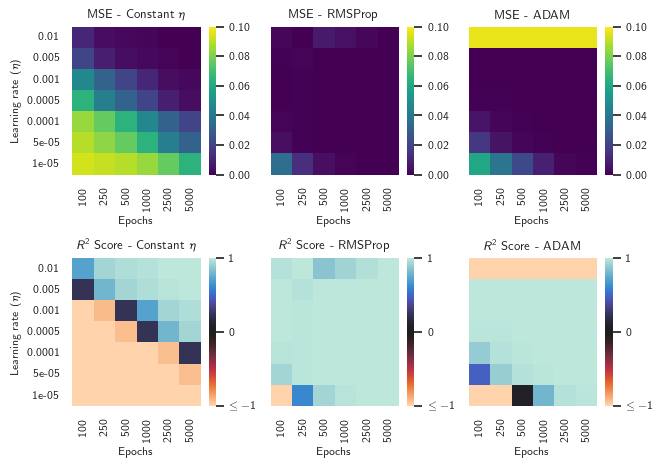

In [ ]:
# plot
fig, axes = plt.subplots(2, 3, figsize=(tw, 12/2.54), sharey=True)

labels = (r'Constant $\eta$', 'RMSProp', 'ADAM')

for i, scheduler in enumerate(schedulers_types):
    sns.heatmap(mse_matrices[i], ax=axes[0, i],
                xticklabels=epochs_range, 
                yticklabels=etas_range,
                cmap="viridis",
                vmin=0,
                vmax=0.10)
    axes[0, i].set_title(f"MSE - {labels[i]}")
    axes[0, i].set_xlabel("Epochs")
    

    sns.heatmap(r2_matrices[i], ax=axes[1, i],
                xticklabels=epochs_range, 
                yticklabels=etas_range, 
                cmap="icefire_r",
                vmin=-1,
                vmax=1)
    axes[1, i].set_title(fr"$R^2$ Score - {labels[i]}")
    axes[1, i].set_xlabel("Epochs")
    cbar = axes[1, i].collections[0].colorbar
    cbar.set_ticks([-1, 0, 1])
    tick_labels = [r"$\leq-1$", '0', '1']
    cbar.set_ticklabels(tick_labels)

axes[0, 0].set_ylabel(r"Learning rate ($\eta$)")
axes[1, 0].set_ylabel(r"Learning rate ($\eta$)")
plt.tight_layout()
saveplot("schedulers_mse_r2")

### Comparison with OLS, deg = 13

In [605]:
start_time = time.time()

lr = LinearRegression_own(intercept=True)
X_train_lr = lr.polynomial_features(x_train, 13)
X_test_lr = lr.polynomial_features(x_test, 13)

theta = lr.fit(X_train_lr, y_train)
predict_lr_test = lr.predict(X_test_lr, theta)
predict_lr_train = lr.predict(X_train_lr, theta)

# ---- compute elapsed time ---- #
end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time

0.0011425018310546875

In [606]:
nn_1l = NeuralNetwork(
    network_input_size=1,
    layer_output_sizes=[50, 1],
    activation_types=['sigmoid', 'sigmoid'],
    cost_type='mse'
)

nn_2l = NeuralNetwork(
    network_input_size=1,
    layer_output_sizes=[100, 100, 1],
    activation_types=['sigmoid', 'sigmoid', 'sigmoid'],
    cost_type='mse'
)

nn_1l._reset_weights()
nn_2l._reset_weights()

nn_1l._create_layers()
nn_2l._create_layers()

nn_1l._define_scheduler(type='constant', eta=1e-3)
nn_2l._define_scheduler(type='constant', eta=1e-3)

nn_1l._train(x_train, y_train, n_epochs=1000)

start_time = time.time()
nn_2l._train(x_train, y_train, n_epochs=1000)
end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

predict_l1_test = nn_1l._predict(x_test)
predict_l2_test = nn_2l._predict(x_test)
predict_l1_train = nn_1l._predict(x_train)
predict_l2_train = nn_2l._predict(x_train)

predicts_test = [predict_lr_test, predict_l1_test, predict_l2_test]
predicts_train = [predict_lr_train, predict_l1_train, predict_l2_train]
labels = ['Linear Regression (deg=13)', 'Neural Network (1L, 50N)', 'Neural Network (2L, 100N)']


4.587545394897461


Linear Regression (deg=13) => Test MSE: 0.161, Test R2: 0.987 | Train MSE: 0.161, Train R2: 0.992
Neural Network (1L, 50N) => Test MSE: 0.155, Test R2: -361.472 | Train MSE: 0.155, Train R2: -295.387
Neural Network (2L, 100N) => Test MSE: 0.004, Test R2: 0.940 | Train MSE: 0.003, Train R2: 0.958


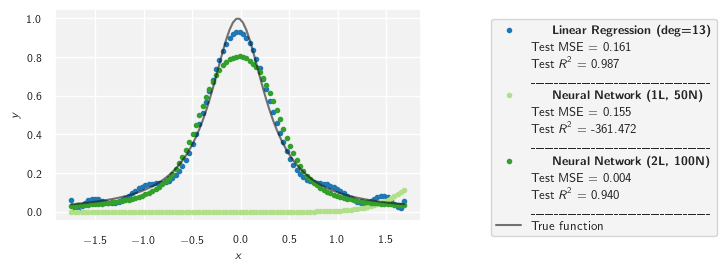

In [577]:
plt.figure(figsize=(12/2.54, 7/2.54))

palette = sns.color_palette("Paired")[1:4]

for i in range(len(predicts_test)):

    mse_test = mse(predicts_test[i], y_test)
    r2_test = r2_score(predicts_test[i], y_test)
    mse_train = mse(predicts_train[i], y_train)
    r2_train = r2_score(predicts_train[i], y_train)
    print(f"{labels[i]} => Test MSE: {mse_test:.3f}, Test R2: {r2_test:.3f} | Train MSE: {mse_train:.3f}, Train R2: {r2_train:.3f}")

    plt.scatter(x_test, predicts_test[i], marker='.', 
                label=rf"\textbf{{{labels[i]}}}\\ Test MSE = {mse_test:.3f}\\ Test $R^2$ = {r2_test:.3f}\\ _______________________________________ \\", 
                color=palette[i])
    plt.scatter(x_train, predicts_train[i], marker='.', color=palette[i])

plt.plot(x, y, c='k', alpha=0.6, label='True function')
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.legend(bbox_to_anchor=(1.5, -0.1), loc='lower center')

plt.savefig("../LaTeX/images/ols_Vs_nn.pdf", bbox_inches='tight')
plt.show()

## Testing against `scikit-learn` functionalities

In [545]:
x = np.linspace(-1, 1, 100).reshape(-1, 1)
y = Runge(x, noise=False)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x = scaler.transform(x)
y = Runge(x, noise=False)


Execution time: 17.98362374305725 seconds
Execution time: 1.417527437210083 seconds
sk Train R^2: 0.9850
sk Test R^2:  0.9871
own Train R^2: 0.9998
own Test R^2:  0.9999


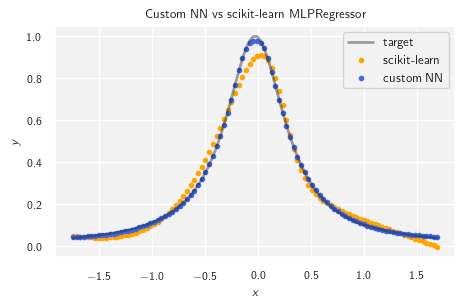

In [578]:
start_time = time.time()

nn_own = NeuralNetwork(
    network_input_size=1,
    layer_output_sizes=[100, 100, 1],
    activation_types=['tanh', 'tanh', 'tanh'], 
    cost_type='mse',
    lbda1=0.0,
    lbda2=1e-4 
)

nn_own._create_layers()
nn_own._define_scheduler(type="adam", eta=1e-3) 
start_time = time.time()
nn_own._train(x_train, y_train, n_epochs=3000, n_batches=10)
print("Execution time: %s seconds" % (time.time() - start_time))

y_pred_train_own = nn_own._predict(x_train) 
y_pred_test_own = nn_own._predict(x_test)

mlp = MLPRegressor(
    hidden_layer_sizes=(100, 100),
    activation='tanh',                
    solver='adam',
    learning_rate_init=1e-3,
    alpha=1e-4,                 
    max_iter=3000,
    random_state=42,
    tol=1e-5
)
mlp.fit(x_train, y_train.ravel())

start_time = time.time()
mlp.fit(x_train, y_train.ravel())
print("Execution time: %s seconds" % (time.time() - start_time))
y_pred_train_sk = mlp.predict(x_train)
y_pred_test_sk = mlp.predict(x_test)


print(f"sk Train R^2: {r2_score(y_train, y_pred_train_sk):.4f}")
print(f"sk Test R^2:  {r2_score(y_test, y_pred_test_sk):.4f}")

print(f"own Train R^2: {r2_score(y_train, y_pred_train_own):.4f}")
print(f"own Test R^2:  {r2_score(y_test, y_pred_test_own):.4f}")

plt.figure(figsize=(12/2.54, 8/2.54))
plt.plot(x, y, 'k-', label="target", lw=2, alpha=0.4)
plt.scatter(x_train, y_pred_train_sk,  
            label="scikit-learn", color='orange', marker='.')
plt.scatter(x_test, y_pred_test_sk, color='orange', marker='.')
plt.scatter(x_train, y_pred_train_own, color='royalblue', label="custom NN", marker='.')
plt.scatter(x_test, y_pred_test_own, color='royalblue', marker='.')

plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Custom NN vs scikit-learn MLPRegressor")
plt.legend()
plt.grid(True)
plt.tight_layout()
saveplot("skvsown")
plt.show()

## Testing different norms

We now stick to Adam and find the relation $\eta/\lambda$ for both L1 and L2 -- 4 matrices in total

In [562]:
mse_matrices_reg = list()
r2_martices_reg = list()

epochs = 500

etas_range = [1e-2, 0.5e-2, 1e-3, 0.5e-3, 1e-4, 0.5e-4, 1e-5]
lbda1_range = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
lbda2_range = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]

for reg_method, lbda_range in zip(['lasso', 'ridge'], [lbda1_range, lbda2_range]):
    mse_matrix_reg = np.zeros((len(lbda_range), len(etas_range)))
    r2_matrix_reg = np.zeros((len(lbda_range), len(etas_range)))

    for i, lbda in enumerate(lbda_range):
        for j, eta in enumerate(etas_range):
            if reg_method == 'lasso':
                nn_reg = NeuralNetwork(
                    network_input_size=1,
                    layer_output_sizes=[50, 50, 1],
                    activation_types=['sigmoid', 'sigmoid', 'sigmoid'],
                    cost_type='mse',
                    regression_method='lasso',
                    lbda1=lbda
                )
            else:
                nn_reg = NeuralNetwork(
                    network_input_size=1,
                    layer_output_sizes=[50, 50, 1],
                    activation_types=['sigmoid', 'sigmoid', 'sigmoid'],
                    cost_type='mse',
                    regression_method='ridge',
                    lbda2=lbda
                )

            nn_reg._reset_weights()
            nn_reg._create_layers()
            nn_reg._define_scheduler('adam', eta=eta)
            nn_reg._train(x_train, y_train, epochs)
            predict = nn_reg._predict(x_test)
            mse_val = mean_squared_error(predict, y_test)
            r2_val = r2_score(predict, y_test)

            mse_matrix_reg[i, j] = mse_val
            r2_matrix_reg[i, j] = r2_val
            print("Reg: {}, lbda = {}, eta = {} => MSE = {}, R2 = {}".format(reg_method, lbda, eta, mse_val, r2_val))
        
    mse_matrices_reg.append(mse_matrix_reg.copy())
    r2_martices_reg.append(r2_matrix_reg.copy())

Reg: lasso, lbda = 1e-05, eta = 0.01 => MSE = 7.226586772047964e-05, R2 = 0.9988285807784717
Reg: lasso, lbda = 1e-05, eta = 0.005 => MSE = 7.766531841252467e-05, R2 = 0.9987491853609629
Reg: lasso, lbda = 1e-05, eta = 0.001 => MSE = 0.00023620757777654378, R2 = 0.9961798593287616
Reg: lasso, lbda = 1e-05, eta = 0.0005 => MSE = 0.000659791875019975, R2 = 0.9894271477991877
Reg: lasso, lbda = 1e-05, eta = 0.0001 => MSE = 0.002905789095860778, R2 = 0.9449146537270556
Reg: lasso, lbda = 1e-05, eta = 5e-05 => MSE = 0.01069183894603502, R2 = 0.6486497125298057
Reg: lasso, lbda = 1e-05, eta = 1e-05 => MSE = 0.042352050442510586, R2 = -13.427618037908866
Reg: lasso, lbda = 0.0001, eta = 0.01 => MSE = 0.00021918965482280455, R2 = 0.9964389757522514
Reg: lasso, lbda = 0.0001, eta = 0.005 => MSE = 0.0005121916567477603, R2 = 0.9918819539720246
Reg: lasso, lbda = 0.0001, eta = 0.001 => MSE = 0.00035967931171161573, R2 = 0.9941627909003656
Reg: lasso, lbda = 0.0001, eta = 0.0005 => MSE = 0.0006307

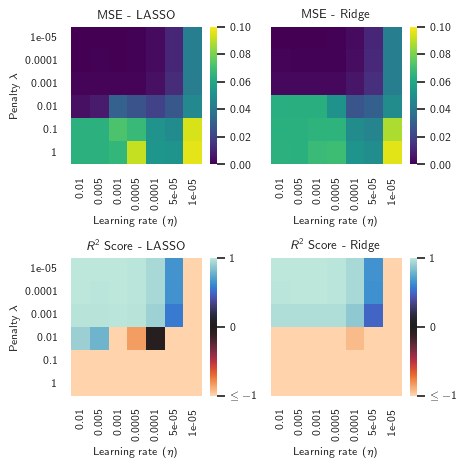

In [ ]:
# plot
fig, axes = plt.subplots(2, 2, figsize=(12/2.54, 12/2.54), sharey=True)
for i, reg_method in enumerate(['LASSO', 'Ridge']):
    sns.heatmap(mse_matrices_reg[i], ax=axes[0, i],
                xticklabels=etas_range, 
                yticklabels=lbda1_range if reg_method == 'lasso' else lbda2_range,
                cmap="viridis",
                vmin=0,
                vmax=0.10)
    axes[0, i].set_title(f"MSE - {reg_method}")
    axes[0, i].set_xlabel(r"Learning rate ($\eta$)")
    

    sns.heatmap(r2_martices_reg[i], ax=axes[1, i],
                xticklabels=etas_range, 
                yticklabels=lbda1_range if reg_method == 'lasso' else lbda2_range, 
                cmap="icefire_r",
                vmin=-1,
                vmax=1)
    axes[1, i].set_title(fr"$R^2$ Score - {reg_method}")
    axes[1, i].set_xlabel(r"Learning rate ($\eta$)")
    axes[0, 0].set_ylabel(r"Penalty $\lambda$")
    axes[1, 0].set_ylabel(r"Penalty $\lambda$")
    cbar = axes[1, i].collections[0].colorbar
    cbar.set_ticks([-1, 0, 1])
    tick_labels = [r"$\leq-1$", '0', '1']
    cbar.set_ticklabels(tick_labels)
plt.tight_layout()
saveplot('nnl1l2')
plt.show()

## Classification  analysis using neural networks
We use the MNIST-784

In [581]:
from sklearn.datasets import fetch_openml

# Fetch the MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')

# Extract data (features) and target (labels)
X = mnist.data
y = mnist.target

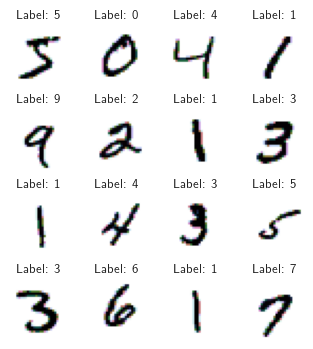

In [582]:
plt.figure(figsize=(cw, 9/2.54))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(X[i].reshape(28, 28), cmap='cubehelix_r')
    plt.title(f"Label: {mnist.target[i]}")
    plt.axis('off')

plt.tight_layout()
saveplot("mnist_samples")
plt.show()

Data scaling and creation of smaller setf for first tries.

In [583]:
X = X / 255.0
y_onehot = np.eye(10)[y.astype(int)]

X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

X_small_train = X_train[:5000]
y_small_train = y_train[:5000]
X_small_test = X_test[:1000]
y_small_test = y_test[:1000]

#### Implementation
We use a flexible number of hidden layers with activation = Leaky ReLU: no vanishing gradients, no dying neurons + Softmax for the last output layer and cross entropy as a cost.

In [585]:
nn_class = NeuralNetwork(
    network_input_size=X.shape[1],
    layer_output_sizes=[128, 64, 10],
    activation_types=['leaky_relu', 'leaky_relu', 'softmax'],
    cost_type='cross_entropy'
)

nn_class._create_layers()
nn_class._define_scheduler('adam', eta=1e-3)
nn_class._train(X_train, y_train, n_epochs=1000, n_batches=20)


In [586]:
predicts_class = nn_class._predict(X_test)
nn_class._accuracy(predicts_class, y_test)

np.float64(0.9245714285714286)

In [587]:
from sklearn.metrics import confusion_matrix

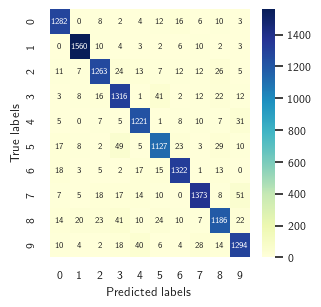

In [596]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# fix encoding mismatch issue - ChatGPT fix
pred_labels = np.argmax(predicts_class, axis=1)

true_labels = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test

cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(cw, 8/2.54))
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', annot_kws={'fontsize': 6}, cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.tight_layout()
saveplot("mnist_cm")
plt.show()
